In [1]:
import matplotlib.pyplot as plt
import numpy as np

# exp_id = np.load('exp_id.npy')
exp_id = 6
exec(open("model_architecture.py").read())

net1 = torch.load('F'+ str(exp_id) +'_net1.pt')
net2 = torch.load('F'+ str(exp_id) +'_net2.pt')

In [1]:
## Save Deep features at fusion layer (needed for perm, LIME, SHAP)
net1.eval()
net2.eval()

test_sz = len(test_loader)*batch_size

deep_feat = torch.zeros(test_sz , 40)
test_labels = torch.zeros(test_sz)

with torch.no_grad():
    for i, data in enumerate(test_loader):
        m1, m2, m3, labels = data
        img1 = m1.to(device)
        img2 = m2.to(device)
        tab = m3.to(device)
        labels = labels.to(device)

        # run the model on the test set to predict labels
        enc_img1 = net1(img1)
        enc_img2 = net1(img2)
        b_sz = len(labels)
        deep_feat[i*128:i*128+b_sz] = torch.cat((enc_img1, enc_img2, tab), dim=1)

        # Save the true labels corresponding all deep features
        test_labels[i*128:i*128+b_sz] = labels

test_labels = test_labels[0:i*128+b_sz]        
deep_feat = deep_feat[0:i*128+b_sz, :]

torch.save(deep_feat,'D1_F'+str(exp_id)+'_test_fusion_tensor.pt' ) 


## Feature importance using permutation method

In [5]:
# Function to test the model with the test dataset and print the accuracy for the test images
net1.eval()
net2.eval()

fn = 40

total = 0.0
perm_iter = 3500
sz = len(deep_feat)
imp = np.zeros(fn)

with torch.no_grad():
    test_labels = test_labels.double().to(device)
    deep_feat = deep_feat.double().to(device)
    
    outputs = net2(deep_feat[:,0:10], deep_feat[:,10:20], deep_feat[:,20:40])
    _, predicted = torch.max(outputs.data, -1)
    
    base_accuracy = ((predicted == test_labels).sum().item())/sz
    
    for k in range(fn):
        accuracy = 0.0
        for i in range(perm_iter):
            idx = torch.randperm(sz)
            perm_deep_feat = deep_feat.clone()
            perm_deep_feat[:,k] = deep_feat[idx,k]

            perm_deep_feat = perm_deep_feat.double().to(device)
            outputs = net2(perm_deep_feat[:,0:10], perm_deep_feat[:,10:20], perm_deep_feat[:,20:40])

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, -1)
            accuracy += ((predicted == test_labels).sum().item())/sz
        # compute the accuracy over all test images
        accuracy = (accuracy / perm_iter)
        
        imp[k] = base_accuracy - accuracy 


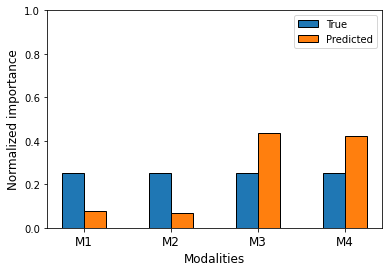

In [6]:
imp_m1 = np.sum((imp[0:10]))
imp_m2 = np.sum((imp[10:20]))
imp_m3 = np.sum((imp[20:30]))
imp_m4 = np.sum((imp[30:40]))

imp_m = np.array( [ imp_m1, imp_m2, imp_m3, imp_m4] ) 
imp_m[imp_m < 0] = 0
imp_m = imp_m/sum(imp_m)

imp_GT = np.load('F'+str(exp_id)+'_imp_gt.npy')

xlabel = ['M1', 'M2','M3','M4']
plt.bar([0-0.125,1-0.125,2-0.125,3-0.125], imp_GT,  edgecolor='k', width=0.25, capsize=2,  label='True')
plt.bar([0+0.125,1+0.125,2+0.125,3+0.125], imp_m,  edgecolor='k', width=0.25, capsize=2,  label='Predicted')
plt.xticks([0,1,2,3],xlabel,fontsize=12)
plt.xlabel('Modalities',fontsize=12)
plt.ylabel('Normalized importance',fontsize=12)
plt.ylim([0,1])
plt.legend()
plt.grid

np.save('F'+str(exp_id)+'_imp_perm', imp_m)